In [60]:
import sys
sys.path.append('..')
import quarantines as Q
import quarantines_mongo as qm
import graph_generators as gg 
import networkx as nx 
import networkit as nk
import pymongo
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from tabulate import tabulate
from scipy import stats
from pprint import pprint
import os 
import random
import experiment_helpers as eh
import utils
import bisect
import powerlaw
from curlyBrace import curlyBrace
sns.set()

In [65]:
TAU = 10.0 
GAMMA = 1.0 
num_init = 25.
tmax = float('inf') 

In [66]:
# ONE FOR EACH ROW 
def make_ba1(N):
    return nx.barabasi_albert_graph(N, 1) 

def make_basic_pl(N):
    theory = powerlaw.Power_Law(xmin=1.0, parameters=[3.0], discrete=True)
    pl_data = [int(_) for _ in theory.generate_random(N)]
    if sum(pl_data) % 2 != 0:
        pl_data[0] += 1 
    return nx.Graph(nx.configuration_model(pl_data))

def make_random_grid(N):
    return nx.Graph(nx.configuration_model([4 for _ in range(N)]))



def make_poisson_graph(N):
    deg_seq = np.random.poisson(size=N, lam=2)
    if sum(deg_seq) % 2 != 0:
        deg_seq[-1] = deg_seq[-1] + 1
    return nx.Graph(nx.configuration_model(deg_seq))


####### ONE FOR EACH COLUMN

def remove_pct_random(graph, pct):
    graph = graph.copy()
    to_remove = random.sample(graph.nodes(), round(len(graph) * pct))
    if len(to_remove) > 0:
        graph.remove_nodes_from(to_remove) 
    return graph 

def remove_pct_deg(graph, pct):
    # removes the top pct fraction of the graph, ordered by degree (descending)
    graph = graph.copy()
    ordered_degrees = [_[0] for _ in sorted(dict(graph.degree()).items(), key=lambda p: p[1], reverse=True)]
    to_remove = ordered_degrees[:round(pct * len(graph))]
    if len(to_remove) > 0:
        graph.remove_nodes_from(to_remove)
    return graph 

def remove_pct_q(graph, pct, tau=TAU, gamma=GAMMA, num_init=num_init):
    graph = graph.copy() 
    if pct == 0.0: 
        return graph 
    return Q.run_until_prop_IR(graph, tau, gamma, num_init/float(len(graph)), float('inf'), 
                             pct, return_summary=False)[0]

####### CELL ACCESSOR$$$$
# graph_gen yields a fxn: (N, pct) -> Graph made by gen_fxn, with pct frac of nodes removed by remove_fxn
def graph_gen_maker(gen_fxn, remove_fxn):
    def generator(N, pct, gen_fxn=gen_fxn, remove_fxn=remove_fxn):
        return remove_fxn(gen_fxn(N), pct)
    return generator
    


In [75]:
############# CHECK FUNCTIONS #####################################
def check_outbreak_single(graph, tau, gamma, num_init, return_count=False):
    # Returns TRUE if outbreak occurs, FALSE ow
    
    # quick fail if init kills everyone 
    if num_init >= 2 * len(graph):
        return False 
    
    sim = Q.run_until_prop_IR(graph, tau, gamma, float(num_init) / len(graph), float('inf'), 1.0)[-1]
    init_infected = set(_[0] for _ in sim.get_statuses(time=0).items() if _[1] == 'I')
    count = 0 
    for trip in sim.transmissions(): 
        if trip[1] in init_infected:
            count += 1
            if count >= num_init:
                return True 
    return False 

def check_outbreak_single_count(graph, tau, gamma, num_init, return_count=False):
    # Returns TRUE if outbreak occurs, FALSE ow
    
    # quick fail if init kills everyone 
    if num_init >= len(graph):
        return 1.0
    print("LEN GRAPH", len(graph))
    sim = Q.run_until_prop_IR(graph, tau, gamma, float(num_init) / len(graph), float('inf'), 1.0)[-1]
    init_infected = set(_[0] for _ in sim.get_statuses(time=0).items() if _[1] == 'I')
    count = 0 
    for trip in sim.transmissions(): 
        if trip[1] in init_infected:
            count += 1
    return count / float(num_init)


def alt_check(graph, tau, gamma, num_init):
    if num_init >= 2 * len(graph):
        return False 
    agg_tup = Q.run_until_prop_IR(graph, tau, gamma, float(num_init) / len(graph), float('inf'), 1.0)[1]
    return agg_tup.get_final_R() > 2 * num_init

def check_outbreak_many(graph_gen, N, pct, tau, gamma, num_init, num_iter=10):
    outputs = [] 
    for _ in range(num_iter):
        graph = graph_gen(N, pct) # NEW GRAPH EVERY RUN
        outputs.append(check_outbreak_single(graph, tau, gamma, num_init))
        #outputs.append(alt_check(graph, tau, gamma, num_init))

    return sum(outputs) / float(num_iter)




def check_outbreak_many_count(graph_gen, N, pct, tau, gamma, num_init, num_iter=10):
    outputs = [] 
    for _ in range(num_iter):
        graph = graph_gen(N, pct) # NEW GRAPH EVERY RUN
        outputs.append(check_outbreak_single_count(graph, tau, gamma, num_init))
        #outputs.append(alt_check(graph, tau, gamma, num_init))

    return sum(outputs)/ float(num_iter), outputs



def check_series(graph_gen, N, tau, gamma, num_init, num_iter=10, start=0.0, step=0.1):
    current_pct = start 
    while True:
        check_val, full_check = check_outbreak_many_count(graph_gen, N, current_pct, tau, gamma, num_init, num_iter=num_iter)
        print("current %.2f | check %.3f | full %s" % (current_pct, check_val, full_check))
        if check_val <=1.0:
            return current_pct
        current_pct += step
        if current_pct >= 1.0:
            return 1.0
        
        
        

def med_of_means(graph_gen, N, tau ,gamma, num_init, num_iter=10, start=0.0, step=0.1, num_median=1):
    output = []
    for _ in range(num_median):
        output.append(check_series(graph_gen, N, tau, gamma, num_init, 
                                   num_iter=num_iter, 
                                  start=start, 
                                  step=step)
                     )
    return np.median(output)
        


In [76]:
# Then the code looks like: 
# ONE FOR EACH ROW 
NUM_INIT = 10
NUM_ITER = 10
START_DICT = {}
STEP = 0.1
N = 10000


output_dict = {}
for gen_name, gen_type in {'ba1': make_ba1, 
                      'pl': make_basic_pl, 
                      'grid': make_random_grid, 
                      'poisson': make_poisson_graph}.items():
    for remove_name, remove_fxn in {'random': remove_pct_random, 
                                  'degree': remove_pct_deg, 
                                  'q': remove_pct_q}.items():
        pair = (gen_name, remove_name)

        print("-" * 50)
        print("PAIR", pair)
        print("-" * 50)

        graph_gen = graph_gen_maker(gen_type, remove_fxn)
        print(graph_gen)
        val = med_of_means(graph_gen, N, TAU, GAMMA, NUM_INIT, num_iter=NUM_ITER, 
                           start=START_DICT.get(pair, 0.0), step=STEP)
        output_dict[pair] = val 


--------------------------------------------------
PAIR ('ba1', 'random')
--------------------------------------------------
<function graph_gen_maker.<locals>.generator at 0x7f4a8f7d2a60>
LEN GRAPH 10000
LEN GRAPH 10000
LEN GRAPH 10000
LEN GRAPH 10000
LEN GRAPH 10000
LEN GRAPH 10000
LEN GRAPH 10000
LEN GRAPH 10000
LEN GRAPH 10000
LEN GRAPH 10000
current 0.00 | check 1.540 | full [3.2, 1.3, 1.7, 1.5, 1.7, 1.1, 1.1, 1.2, 1.5, 1.1]
LEN GRAPH 9000
LEN GRAPH 9000
LEN GRAPH 9000
LEN GRAPH 9000
LEN GRAPH 9000
LEN GRAPH 9000
LEN GRAPH 9000
LEN GRAPH 9000
LEN GRAPH 9000
LEN GRAPH 9000
current 0.10 | check 1.320 | full [1.3, 1.2, 1.0, 0.9, 1.0, 1.5, 1.1, 1.2, 1.9, 2.1]
LEN GRAPH 8000
LEN GRAPH 8000
LEN GRAPH 8000
LEN GRAPH 8000
LEN GRAPH 8000
LEN GRAPH 8000
LEN GRAPH 8000
LEN GRAPH 8000
LEN GRAPH 8000
LEN GRAPH 8000
current 0.20 | check 1.260 | full [0.9, 0.9, 1.6, 0.6, 1.9, 1.3, 1.1, 1.8, 1.3, 1.2]
LEN GRAPH 7000
LEN GRAPH 7000
LEN GRAPH 7000
LEN GRAPH 7000
LEN GRAPH 7000
LEN GRAPH 7000
LEN GR

LEN GRAPH 8654
LEN GRAPH 9888
LEN GRAPH 8653
LEN GRAPH 8018
LEN GRAPH 9510
LEN GRAPH 8381
LEN GRAPH 8764
LEN GRAPH 8502
LEN GRAPH 8697
LEN GRAPH 8234
current 0.70 | check 1.100 | full [1.1, 1.3, 1.4, 1.1, 0.8, 1.1, 1.0, 0.7, 1.1, 1.4]
LEN GRAPH 8080
LEN GRAPH 8600
LEN GRAPH 8954
LEN GRAPH 8711
LEN GRAPH 8927
LEN GRAPH 8748
LEN GRAPH 8586
LEN GRAPH 9218
LEN GRAPH 8601
LEN GRAPH 8295
current 0.80 | check 1.190 | full [1.8, 1.3, 0.9, 1.1, 1.2, 1.2, 1.1, 1.0, 1.0, 1.3]
LEN GRAPH 8484
LEN GRAPH 7925
LEN GRAPH 8621
LEN GRAPH 9770
LEN GRAPH 9240
LEN GRAPH 8374
LEN GRAPH 8496
LEN GRAPH 9109
LEN GRAPH 8437
LEN GRAPH 9884
current 0.90 | check 1.140 | full [0.9, 1.2, 1.0, 1.3, 0.8, 1.3, 1.4, 1.2, 1.2, 1.1]
LEN GRAPH 9526
LEN GRAPH 8718
LEN GRAPH 8700
LEN GRAPH 9718
LEN GRAPH 8905
LEN GRAPH 9704
LEN GRAPH 8803
LEN GRAPH 8407
LEN GRAPH 8578
LEN GRAPH 9147
current 1.00 | check 1.370 | full [1.2, 1.2, 1.4, 1.9, 1.2, 1.3, 1.0, 1.5, 1.8, 1.2]
--------------------------------------------------
PAIR ('gr

LEN GRAPH 10000
LEN GRAPH 10000
LEN GRAPH 10000
LEN GRAPH 10000
LEN GRAPH 10000
LEN GRAPH 10000
LEN GRAPH 10000
LEN GRAPH 10000
LEN GRAPH 10000
current 0.00 | check 1.680 | full [1.8, 1.9, 1.2, 1.7, 1.1, 1.3, 2.5, 2.1, 1.7, 1.5]
LEN GRAPH 9000
LEN GRAPH 9000
LEN GRAPH 9000
LEN GRAPH 9000
LEN GRAPH 9000
LEN GRAPH 9000
LEN GRAPH 9000
LEN GRAPH 9000
LEN GRAPH 9000
LEN GRAPH 9000
current 0.10 | check 1.740 | full [2.1, 2.3, 1.1, 1.7, 2.1, 1.7, 1.8, 0.8, 1.4, 2.4]
LEN GRAPH 8000
LEN GRAPH 8000
LEN GRAPH 8000
LEN GRAPH 8000
LEN GRAPH 8000
LEN GRAPH 8000
LEN GRAPH 8000
LEN GRAPH 8000
LEN GRAPH 8000
LEN GRAPH 8000
current 0.20 | check 1.500 | full [1.5, 2.0, 1.2, 1.6, 1.1, 1.8, 1.0, 1.8, 1.7, 1.3]
LEN GRAPH 7000
LEN GRAPH 7000
LEN GRAPH 7000
LEN GRAPH 7000
LEN GRAPH 7000
LEN GRAPH 7000
LEN GRAPH 7000
LEN GRAPH 7000
LEN GRAPH 7000
LEN GRAPH 7000
current 0.30 | check 1.140 | full [1.4, 1.2, 1.1, 1.3, 1.8, 1.1, 0.5, 1.2, 0.7, 1.1]
LEN GRAPH 6000
LEN GRAPH 6000
LEN GRAPH 6000
LEN GRAPH 6000
LEN GR

In [77]:
diff_check = output_dict

In [80]:
diff_trips = [(k[0], k[1], v) for k, v in diff_check.items()]
print(tabulate(diff_trips, headers=['graph', 'remove', 'val']))

graph    remove      val
-------  --------  -----
ba1      random      0.5
ba1      degree      0.1
ba1      q           1
pl       random      0.1
pl       degree      0.1
pl       q           1
grid     random      0.8
grid     degree      0.8
grid     q           1
poisson  random      0.5
poisson  degree      0.2
poisson  q           0.5


In [ ]:
init10_neighbor_dict = output_dict

In [ ]:
r1_neighbor_dict = #output_dict

In [ ]:
altcheck_output #= output_dict

In [ ]:
r5_neighbor_dict #= output_dict

In [ ]:
els = []
for k, v in r5_neighbor_dict.items():
    els.append((k[0], k[1], v, r1_neighbor_dict[k]))
print(tabulate(els, headers=['graph', 'remove', 'R=5', 'R=1']))

In [ ]:
r10_output_dict #=3 output_dict

In [ ]:
r1_output_dict #= 3output_dict

In [ ]:
grid_deg = graph_gen_maker(make_random_grid, remove_pct_deg)
check_outbreak_many(grid_deg, 10000, 0.0, TAU, GAMMA, 50)

In [ ]:
# BA_Random vs BA_deg 
ba_rand = graph_gen_maker(make_ba1, remove_pct_random)
ba_deg = graph_gen_maker(make_ba1, remove_pct_deg)

avg_deg = lambda G: len(G.edges()) / (0.5 * len(G))

In [ ]:
small_g = ba_deg(N, 0.5)

In [ ]:
len(small_g)

In [41]:
ba10 = nx.barabasi_albert_graph(10000, 10) #make_ba1(10000)
random_out = remove_pct_random(ba10, 0.8)
Q_out = remove_pct_q(ba10, 0.8)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


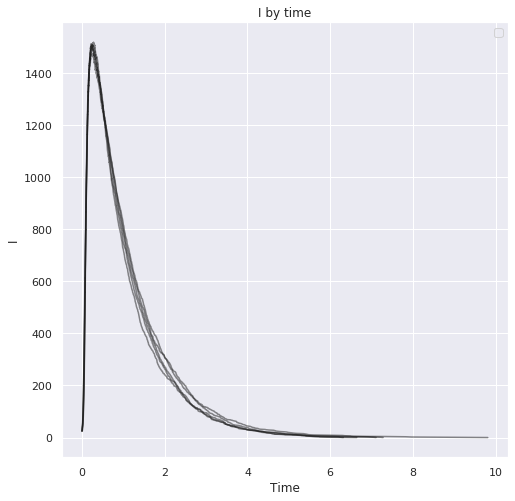

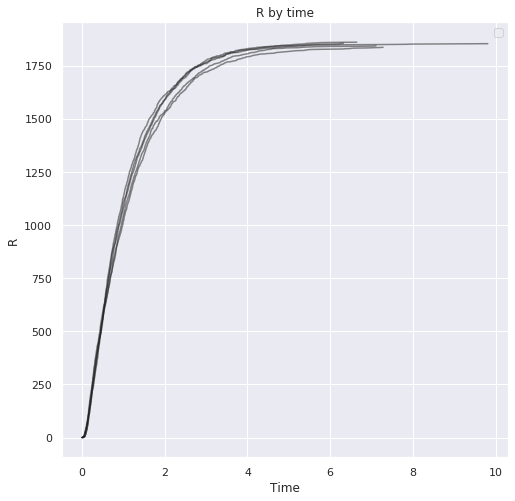

In [42]:
QPROP = [00.0]
Q.quarantine_by_prop(random_out, 10.0, 1.0, 25.0 / len(random_out), QPROP, float('inf'), num_iter=5).plot_single()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


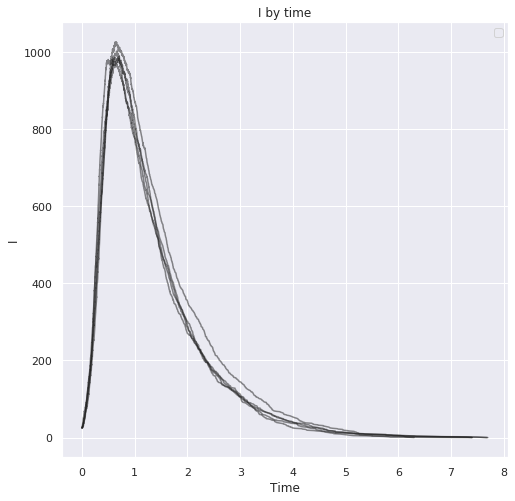

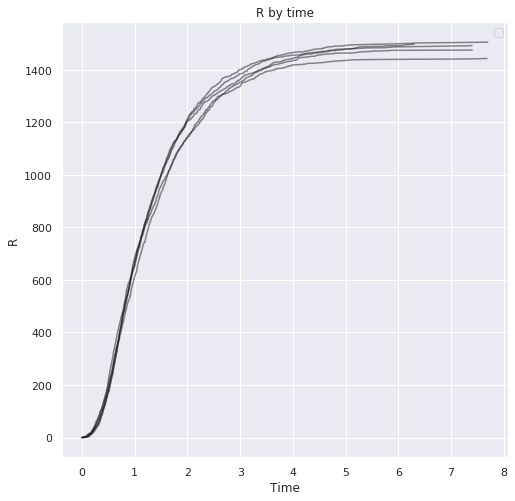

In [43]:
QPROP = [00.0]
Q.quarantine_by_prop(Q_out, 10.0, 1.0, 25.0 / len(Q_out), QPROP, float('inf'), num_iter=5).plot_single()

In [54]:
ba1_random = graph_gen_maker(make_ba1, remove_pct_random)
#def check_outbreak_many_count(graph_gen, N, pct, tau, gamma, num_init, num_iter=10):
check_outbreak_many_count(ba1_random, 10 * 1000, 0.5, 10.0, 1.0, 20)

(0.8099999999999999, [0.5, 0.85, 0.6, 0.95, 0.65, 1.25, 1.1, 0.8, 0.75, 0.65])

In [59]:
ba1_Q = graph_gen_maker(make_ba1, remove_pct_q)
#def check_outbreak_many_count(graph_gen, N, pct, tau, gamma, num_init, num_iter=10):
check_outbreak_many_count(ba1_Q, 10 * 1000, 0.8, 10.0, 1.0, 20)

(1.445, [1.55, 1.1, 1.2, 1.7, 1.25, 1.35, 0.85, 2.8, 1.15, 1.5])